# A behavioural analog to BCI training : results

Statistics and simple plots of the results of the experiment (technical test). 

This notebook does not figure much computational modeling (yet).


Let's start by importing the necessary packages as well as the data : 

 - Loaded the task results for study 66f96c31e69227986334a027 
    (16 subjects.)
 - Loaded the task results for study 66d086503c0a69291c361b67 
    (40 subjects.)
Total : 56 subjects
55 subjects remaining after removing problematic subjects.
A total of 14/6050 actions were missed. (0.23 %)
 - Loaded the task results for study 6703ab18d345eaa4893587e0 
    (49 subjects.)
 - Loaded the task results for study 66f9aee8210357265a5958fc 
    (50 subjects.)
 - Loaded the task results for study 6703ab1a7ea30557549dc6da 
    (50 subjects.)
Total : 149 subjects
145 subjects remaining after removing problematic subjects.
A total of 33/15950 actions were missed. (0.21 %)
(200, 3)


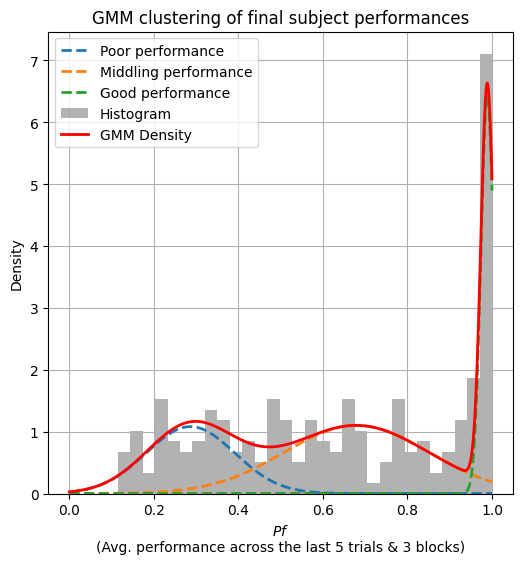

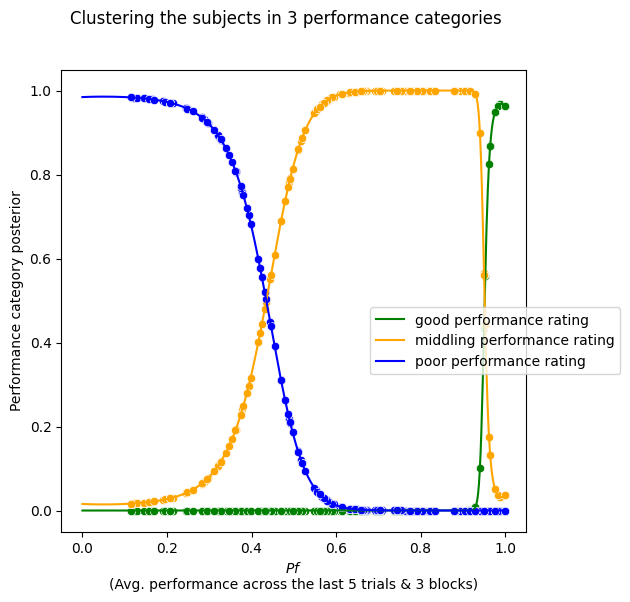

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\analysis_tools\dataframe_from_raw_data.py:348: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


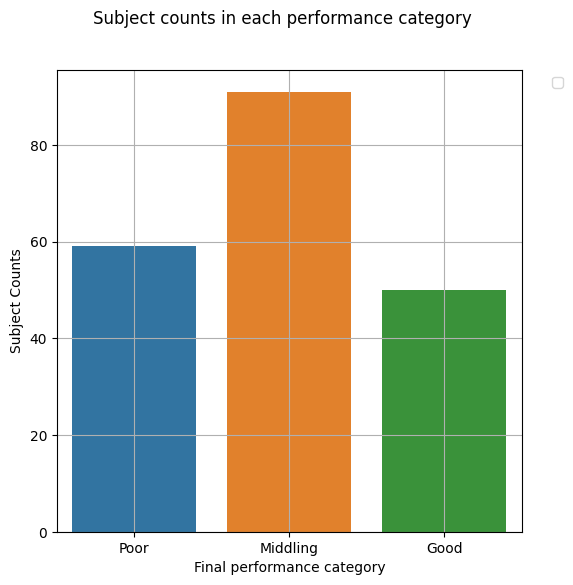

In [1]:

import sys,os
import pickle

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly as pltly
import plotly.express as px
import plotly.graph_objects as go

from sklearn.mixture import GaussianMixture

from jax import vmap
import jax.numpy as jnp

# + local functions : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
from analysis_tools.preprocess import get_preprocessed_data_from_df
from analysis_tools.dataframe_from_raw_data import get_full_dataframe_from_raw_data

LLM_CLASSIFS_PATH = os.path.join("results","llm_classifications","29_01.data")

STUDIES_EXTRACTION_CODES = {
    # "study_1" : {
    #     "dict_code" : "002",
    #     "internal_task_id" : "002",
    #     "studies_id" : None,
    #     "exclude_subjects" : ["5c9cb670b472d0001295f377"],
    #     "feedback_noise_bins" : [0,0.2,0.4,1]
    # },
    "study_2" : {
        "dict_code" : "003_1",
        "internal_task_id" : "003",
        "studies_id" :  ["66f96c31e69227986334a027","66d086503c0a69291c361b67"],
        "exclude_subjects" : ["615c1741d4630b25e6bc1cb9"],
        "feedback_noise_bins" : [0,0.05,0.15,1]
    },
    "study_3" : {
        "dict_code" : "003_2",
        "internal_task_id" : "003",
        "studies_id" : ["6703ab18d345eaa4893587e0","66f9aee8210357265a5958fc","6703ab1a7ea30557549dc6da"],
        "exclude_subjects" : ["611d60c383f4f70ff4bc99fd", "66a74bdfdcaccdc0703894d5",
                              "667d92f2ea5c1542f417285d", "6548f570022275786186ffbd"],
        "feedback_noise_bins" : [0,0.05,0.15,1]
    }
}

LAST_T_TIMESTEPS = 5
LAST_K_TRIALS = 3
subjects_df = get_full_dataframe_from_raw_data(STUDIES_EXTRACTION_CODES,LLM_CLASSIFS_PATH,LAST_T_TIMESTEPS,LAST_K_TRIALS)

## Interesting questions : 

How do our participants decision-making evolve when they get a negative feedback ? A positive feedback ?


C:\Users\annic\AppData\Local\Temp\ipykernel_35920\1128351481.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df["dist_between_successive"] = list(flattened_distance)


Index(['subject_id', 'task_code', 'lang', 'browser', 'N_trials', 'N_tmstps',
       'start_date', 'finish_date', 'finished_clock', 'completedTask',
       'N_exited_fullscreen', 'N_missed_actions', 'canvas_explore_points',
       'mandatory_q1', 'mandatory_q2', 'optional_q1', 'optional_q2',
       'optional_q3', 'canvas_size', 'Submission id', 'Participant id',
       'Status', 'Custom study tncs accepted at', 'Started at', 'Completed at',
       'Reviewed at', 'Archived at', 'Time taken', 'Completion code',
       'Total approvals', 'Fluent languages', 'Age', 'Sex',
       'Ethnicity simplified', 'Country of birth', 'Country of residence',
       'Nationality', 'Language', 'Student status', 'Employment status',
       'Nationality_red', 'feedback_noise_std',
       'application_measured_timetaken', 'question_0', 'question_1',
       'question_2', 'question_3', 'question_4', 'question_5',
       'raw_feedback_values', 'raw_realtime_values', 'realtime_values',
       'grid_layout', 'sub

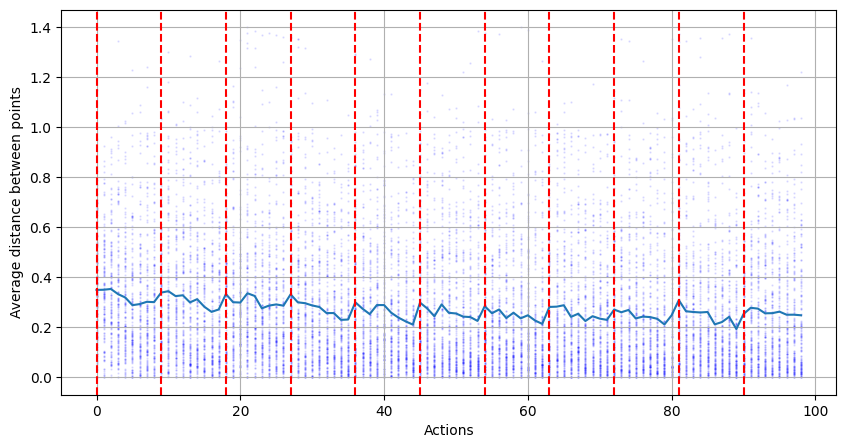

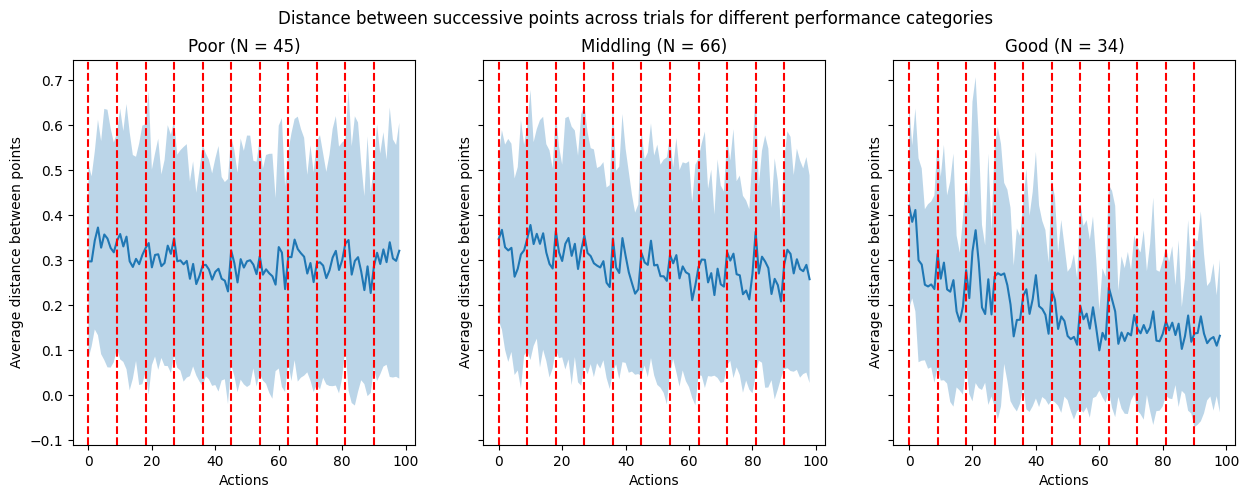

In [2]:
print(subjects_df.keys())

copy_df = subjects_df[subjects_df["study_name"]=="study_3"]

# Difference between raw points at times t and t+1
points = np.stack(copy_df["raw_points"])

Nsubj,Ntrials,Nactions,Npoints,Nfeatures = points.shape

points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)
avg_dist = (dist_points1 + dist_points2)/2.0
flattened_distance = np.reshape(avg_dist,(Nsubj,-1))
copy_df["dist_between_successive"] = list(flattened_distance)
print(Nactions)

# Average distance between points :
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.grid()
for subj in range(Nsubj):
    ax.scatter(np.arange(flattened_distance[subj].size),flattened_distance[subj],c="b",alpha=0.1,s=0.5)
ax.plot(np.arange(flattened_distance[subj].size),np.mean(flattened_distance,axis=0))
for trial in range(Ntrials):
    ax.axvline(trial*(Nactions-1),linestyle="--",color="r")
ax.set_xlabel("Actions")
ax.set_ylabel("Average distance between points")


# Group by performances : 
Nsubcat = 3
fig,axs = plt.subplots(1,Nsubcat,figsize=(15,5),sharey=True)
fig.suptitle("Distance between successive points across trials for different performance categories")
perf = list(copy_df["final_performance"])

perf_bins = np.linspace(0-1e-5,1+1e-5,Nsubcat+1)
category = np.digitize(perf,perf_bins) - 1


perfcats = ["Poor","Middling","Good"]
for score in range(Nsubcat):
    ax = axs[score]    
    filtered_subjects = copy_df[copy_df["performance_category"] == perfcats[score]]
    
    filtered_metric = np.stack(filtered_subjects["dist_between_successive"])
    
    print(filtered_metric.shape)
    avg_plot = np.mean(filtered_metric,axis=0)
    std_plot = np.std(filtered_metric,axis=0)
    
    ax.fill_between(np.arange(avg_plot.shape[0]),avg_plot-std_plot,avg_plot+std_plot,alpha=0.3)
    ax.plot(np.arange(avg_plot.shape[0]),avg_plot)
    for trial in range(Ntrials):
        ax.axvline(trial*(Nactions-1),linestyle="--",color="r")
    ax.set_xlabel("Actions")
    ax.set_ylabel("Average distance between points")
    ax.set_title("{} (N = {})".format( perfcats[score],filtered_metric.shape[0]))


The exploration / exploitation shift is clearly visible in the last category of subjects, with a distinct decrease in the average variation in point position. This is far less visible in less successful subject categories.

In [3]:
# look_at_T_trials = 10

# # Observations : 
# list_of_subjects_rtf = list(subjects_df["realtime_values"])
# all_subject_obs = {"gauge_level":[],"delta_gauge":[]}
# for _s,_subj_feedback_series in enumerate(list_of_subjects_rtf):                   
#     list_of_last_fb = []
#     list_of_deltas = []
#     for trial_series in _subj_feedback_series:
#         trial_last_fbs = []
#         trial_delta_fbs = []
#         for timestep_series in trial_series:
#             initial_feedback_value = timestep_series[0][...,1]
#             final_feedback_value = timestep_series[-1][...,1]
            
#             # print(timestep_series[0,:])
            
#             trial_last_fbs.append(final_feedback_value)
            
#             delta_feedback = final_feedback_value - initial_feedback_value
#             trial_delta_fbs.append(delta_feedback)
                
#         list_of_last_fb.append(trial_last_fbs)
#         list_of_deltas.append(trial_delta_fbs)
    
#     all_subject_obs["gauge_level" ].append(np.array(list_of_last_fb))
#     all_subject_obs["delta_gauge" ].append(np.array(list_of_deltas))

# # Action data :
# all_barycenters = np.stack(subjects_df["action_barycenters"],axis=0)
# all_angles = np.stack(subjects_df["action_angles"],axis=0)
# all_distances = np.stack(subjects_df["action_distances"],axis=0)
# all_dist_to_center = vmap(vmap(vmap(lambda x : jnp.linalg.norm(x-jnp.array([0.5,0.5])))))(all_barycenters)

# # Observation data :
# gauge_levels = np.array(all_subject_obs["gauge_level"])
# delta_gauges = np.array(all_subject_obs["delta_gauge"])


# positive_feedbacks = delta_gauges>=0
# negative_feedbacks = delta_gauges<0

# delta_feedbacks = np.reshape(negative_feedbacks[:,-look_at_T_trials:,1:-1],(Nsubj,-1))
#                                 # Remove the first timestep of each trial (reset to 0)
#                                 # And the last of each trial (no action after that one !)
#                                 # Also remove the second observation because only one action has been done before (thereofre, no action variation)

# # print(negative_feedbacks)
# print("{} negatives /{} positives".format(np.sum(negative_feedbacks),np.sum(positive_feedbacks)))
# print("{} / {} remaining after removing edge actions".format(np.sum(delta_feedbacks),np.sum(1-delta_feedbacks)))


# # Differences between barycenters at time t and time t+1 :
# diff_barycenters = np.linalg.norm(all_barycenters[:,:,1:,:] - all_barycenters[:,:,:-1,:],axis=-1)
# # Differences between angles at time t and time t+1 :
# diff_angle = all_angles[:,:,1:] - all_angles[:,:,:-1]
# # Differences between distances at time t and time t+1 :
# diff_distances = all_distances[:,:,1:] - all_distances[:,:,:-1]
# Nsubj = diff_barycenters.shape[0]




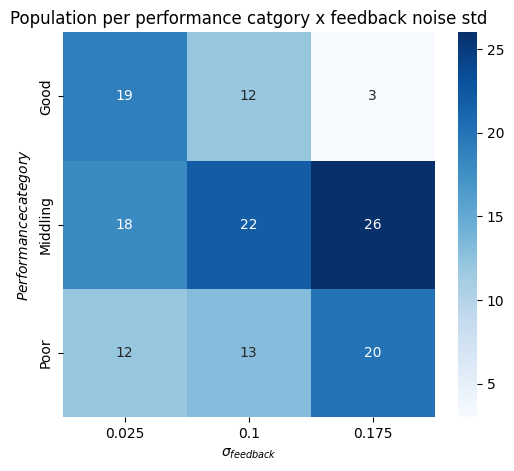

In [ ]:
copy_df = subjects_df[subjects_df["study_name"]=="study_3"]
# Quick counting of the categories of subjects :
# Create a contingency table (cross-tabulation) of counts
matrix = pd.crosstab(copy_df['performance_category'],copy_df['feedback_noise_std'])


# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')  # `annot=True` shows counts

# Add labels
plt.title("Population per performance catgory x feedback noise std")
plt.xlabel("$\sigma_{feedback}$")
plt.ylabel("$Performance category$")

plt.show()


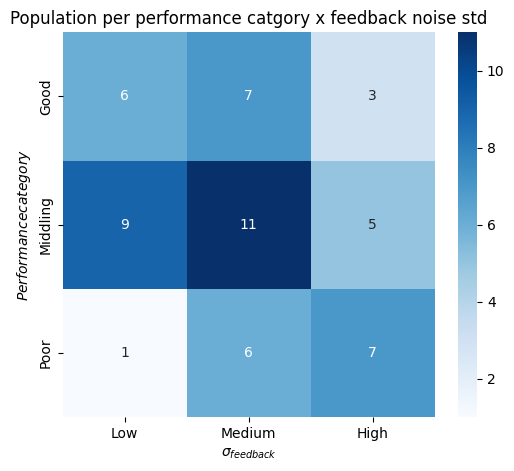

In [5]:
copy_df = subjects_df[subjects_df["study_name"]=="study_2"]
# Quick counting of the categories of subjects :
# Create a contingency table (cross-tabulation) of counts
matrix = pd.crosstab(copy_df['performance_category'],copy_df['noise_category'])


# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')  # `annot=True` shows counts

# Add labels
plt.title("Population per performance catgory x feedback noise std")
plt.xlabel("$\sigma_{feedback}$")
plt.ylabel("$Performance category$")

plt.show()


Question : for a single action modality, how does the intensity of a variation relate to the variation of the other modalities.

5352 negatives /10598 positives
2004 / 3216 remaining after removing edge actions
Statistical Testing  ! #######################################
Testing for metric dpos ---------
  Shapiro test for normality - noise = 0.025, after + Feedback --->> ShapiroResult(statistic=np.float64(0.9633820193079303), pvalue=np.float64(0.1305125254721547))
  Shapiro test for normality - noise = 0.025, after - Feedback --->> ShapiroResult(statistic=np.float64(0.9906354909639998), pvalue=np.float64(0.9625147490620307))
  Shapiro test for normality - noise = 0.1, after + Feedback --->> ShapiroResult(statistic=np.float64(0.9265441136520789), pvalue=np.float64(0.005687655229123878))
  Shapiro test for normality - noise = 0.1, after - Feedback --->> ShapiroResult(statistic=np.float64(0.9349255043233737), pvalue=np.float64(0.011497320027025333))
  Shapiro test for normality - noise = 0.175, after + Feedback --->> ShapiroResult(statistic=np.float64(0.9752797625509947), pvalue=np.float64(0.38704735208479923))


C:\Users\annic\AppData\Local\Temp\ipykernel_35920\363791726.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["after + Feedback"] = assign_plus_fb
C:\Users\annic\AppData\Local\Temp\ipykernel_35920\363791726.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["after - Feedback"] = assign_ng_fb
c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the 

                          Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            dang     
No. Observations:             290                Method:                        REML     
No. Groups:                   145                Scale:                         0.1072   
Min. group size:              2                  Log-Likelihood:                -230.0642
Max. group size:              2                  Converged:                     Yes      
Mean group size:              2.0                                                        
-----------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                       0.666    0.104  6.423 0.000  0.463  0.869
after_x[T.after - Feedback]         

C:\Users\annic\AppData\Local\Temp\ipykernel_35920\363791726.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["after + Feedback"] = assign_plus_fb
C:\Users\annic\AppData\Local\Temp\ipykernel_35920\363791726.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["after - Feedback"] = assign_ng_fb
c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the 

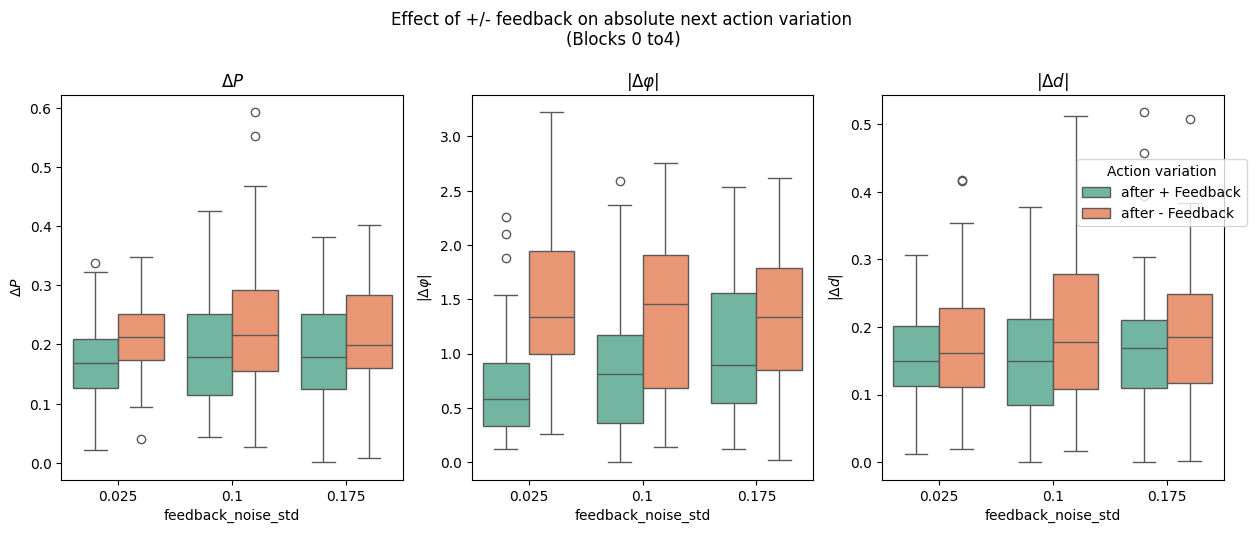

In [22]:
copy_df = subjects_df[subjects_df["study_name"]=="study_3"]

look_between_a = 0
look_between_b = 4


# Difference between raw points at times t and t+1
points = np.stack(copy_df["raw_points"])
Nsubj,Ntrials,Nactions,Npoints,Nfeatures = points.shape

points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
avg_dist = (dist_points1 + dist_points2)/2.0
flattened_distance = np.reshape(avg_dist,(Nsubj,-1))


# Observations : 
list_of_subjects_rtf = list(copy_df["realtime_values"])
all_subject_obs = {"gauge_level":[],"delta_gauge":[]}
for _s,_subj_feedback_series in enumerate(list_of_subjects_rtf):                   
    list_of_last_fb = []
    list_of_deltas = []
    for trial_series in _subj_feedback_series:
        trial_last_fbs = []
        trial_delta_fbs = []
        for timestep_series in trial_series:
            initial_feedback_value = timestep_series[0][...,1]
            final_feedback_value = timestep_series[-1][...,1]
            
            # print(timestep_series[0,:])
            
            trial_last_fbs.append(final_feedback_value)
            
            delta_feedback = final_feedback_value - initial_feedback_value
            trial_delta_fbs.append(delta_feedback)
                
        list_of_last_fb.append(trial_last_fbs)
        list_of_deltas.append(trial_delta_fbs)
    
    all_subject_obs["gauge_level" ].append(np.array(list_of_last_fb))
    all_subject_obs["delta_gauge" ].append(np.array(list_of_deltas))

# Action data :
all_barycenters = np.stack(copy_df["action_barycenters"],axis=0)
all_angles = np.stack(copy_df["action_angles"],axis=0)
all_distances = np.stack(copy_df["action_distances"],axis=0)
all_dist_to_center = vmap(vmap(vmap(lambda x : jnp.linalg.norm(x-jnp.array([0.5,0.5])))))(all_barycenters)

# Observation data :
gauge_levels = np.array(all_subject_obs["gauge_level"])
delta_gauges = np.array(all_subject_obs["delta_gauge"])

positive_feedbacks = delta_gauges>=0
negative_feedbacks = delta_gauges<0

delta_feedbacks = np.reshape(negative_feedbacks[:,look_between_a:look_between_b,1:-1],(Nsubj,-1))
                                # Remove the first timestep of each trial (reset to 0)
                                # And the last of each trial (no action after that one !)
                                # Also remove the second observation because only one action has been done before (thereofre, no action variation)

# print(negative_feedbacks)
print("{} negatives /{} positives".format(np.sum(negative_feedbacks),np.sum(positive_feedbacks)))
print("{} / {} remaining after removing edge actions".format(np.sum(delta_feedbacks),np.sum(1-delta_feedbacks)))


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,1:,:] - all_barycenters[:,:,:-1,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,1:] - all_angles[:,:,:-1]
# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,1:] - all_distances[:,:,:-1]
Nsubj = diff_barycenters.shape[0]

# Get the actions of interest :
rdiff_angle = np.reshape(diff_angle[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_barycenters = np.reshape(diff_barycenters[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_distances = np.reshape(diff_distances[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_points = np.reshape(avg_dist[:,look_between_a:look_between_b],(Nsubj,-1))

metrics_analyzed = [rdiff_barycenters,rdiff_angle,rdiff_distances]
labels_simple = ["dpos","dang","ddist"]
labels_analyzed = [r"$\Delta P$",r"$| \Delta \varphi |$",r"$| \Delta d |$"]
perf_categories = ["Poor","Middling","Good"]


print("Statistical Testing  ! #######################################")
from scipy.stats import shapiro,kruskal
from scipy.stats import kstest,wilcoxon
from scipy.stats import friedmanchisquare

import scikit_posthocs as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
for i,(metric,label,fancylabel) in enumerate(zip(metrics_analyzed,labels_simple,labels_analyzed)):
    print('Testing for metric {} ---------'.format(label))
    
    metric_analyzed = np.abs(metric) # Take the absolute value

    plot_df = copy_df[['subject_id' , 'final_performance', 'feedback_noise_std', 'performance_category']]
    
    assign_plus_fb,assign_ng_fb = [],[]
    for subj in range(Nsubj):
        action_variation_after_positive_feedback = metric_analyzed[subj,~delta_feedbacks[subj]]        
        action_variation_after_negative_feedback = metric_analyzed[subj,delta_feedbacks[subj]]

        assign_plus_fb.append(np.mean(action_variation_after_positive_feedback))
        assign_ng_fb.append(np.mean(action_variation_after_negative_feedback))
    
    plot_df["after + Feedback"] = assign_plus_fb
    plot_df["after - Feedback"] = assign_ng_fb
    
    # Reshape the data to long format
    df_long = plot_df.melt(id_vars=["subject_id","feedback_noise_std"], 
                    value_vars=["after + Feedback", "after - Feedback"], 
                    var_name="after_x", 
                    value_name=label)

    metric_by_group = list(df_long.groupby(['feedback_noise_std','after_x'])[label]) 
    for ((noise_category,fb_var),subjects_array) in metric_by_group :
        # logtime = np.log(subject_array.astype(float))
        print("  Shapiro test for normality - noise = {}, {} --->> {}".format(noise_category,fb_var,shapiro(subjects_array)))
    
    # Compare paired data : 
    print("  Wilcoxon signed-rank test for + and - feedbacks for all noise conditions :")
    for noise_category in np.unique(df_long["feedback_noise_std"]):
        
        pos_fb = df_long[(df_long["feedback_noise_std"]==noise_category) & (df_long["after_x"]=="after + Feedback")][label]
        neg_fb = df_long[(df_long["feedback_noise_std"]==noise_category) & (df_long["after_x"]=="after - Feedback")][label]
        print("     Noise category : {} -- Result : {}".format(noise_category,wilcoxon(pos_fb,neg_fb)))
    
    
    # GLMM fitting to explain the variation of the metric across mixed conditions :
    # print(df_long.head())
    model = smf.mixedlm(
        label + " ~ feedback_noise_std * after_x",  # Fixed effects
        df_long,
        groups=df_long["subject_id"],  # Random intercept per subject
        re_formula="1"  # Random intercept only
    )
    result = model.fit()

    # Print the summary
    print(result.summary())

print("##############################################################")





fig,firstaxs = plt.subplots(1,3,figsize=(15,5),sharex=True)

fig.suptitle("Effect of +/- feedback on absolute next action variation \n(Blocks {} to{})".format(look_between_a,look_between_b),y=1.05)
for i,(metric,label,fancylabel) in enumerate(zip(metrics_analyzed,labels_simple,labels_analyzed)):
    ax = firstaxs[i]
    metric_analyzed = np.abs(metric) # Take the absolute value

    plot_df = copy_df[['subject_id' , 'final_performance', 'feedback_noise_std', 'performance_category']]
    
    assign_plus_fb,assign_ng_fb = [],[]
    for subj in range(Nsubj):
        action_variation_after_positive_feedback = metric_analyzed[subj,~delta_feedbacks[subj]]        
        action_variation_after_negative_feedback = metric_analyzed[subj,delta_feedbacks[subj]]

        assign_plus_fb.append(np.mean(action_variation_after_positive_feedback))
        assign_ng_fb.append(np.mean(action_variation_after_negative_feedback))
    
    plot_df["after + Feedback"] = assign_plus_fb
    plot_df["after - Feedback"] = assign_ng_fb
    
    # Reshape the data to long format
    df_long = plot_df.melt(id_vars=["subject_id","feedback_noise_std"], 
                    value_vars=["after + Feedback", "after - Feedback"], 
                    var_name="after_x", 
                    value_name=label)
    
    g = sns.boxplot(
        ax = ax,
        data=df_long,
        x="feedback_noise_std",       # Categories on the x-axis
        y=label,          # Scalar values for the boxplot
        hue="after_x",     # Differentiate data1 and data2 with colors
        palette="Set2"      # Color palette
    )
    ax.set_ylabel(fancylabel)
    ax.set_title(fancylabel)
    ax.legend_.remove()
    
    # Add the legend to the figure
    plt.legend(
        title="Action variation",       # Legend title
        loc="upper left",       # Adjust position relative to figure
        bbox_to_anchor=(0.55, 0.85)  # Position: (x, y)
    )



5352 negatives /10598 positives
2004 / 3216 remaining after removing edge actions
Statistical Testing  ! #######################################
Testing for metric dpos ---------
  Shapiro test for normality - noise = 0.025, after + Feedback --->> ShapiroResult(statistic=np.float64(0.9633820193079303), pvalue=np.float64(0.1305125254721547))
  Shapiro test for normality - noise = 0.025, after - Feedback --->> ShapiroResult(statistic=np.float64(0.9906354909639998), pvalue=np.float64(0.9625147490620307))
  Shapiro test for normality - noise = 0.1, after + Feedback --->> ShapiroResult(statistic=np.float64(0.9265441136520789), pvalue=np.float64(0.005687655229123878))
  Shapiro test for normality - noise = 0.1, after - Feedback --->> ShapiroResult(statistic=np.float64(0.9349255043233737), pvalue=np.float64(0.011497320027025333))
  Shapiro test for normality - noise = 0.175, after + Feedback --->> ShapiroResult(statistic=np.float64(0.9752797625509947), pvalue=np.float64(0.38704735208479923))


C:\Users\annic\AppData\Local\Temp\ipykernel_35920\363791726.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["after + Feedback"] = assign_plus_fb
C:\Users\annic\AppData\Local\Temp\ipykernel_35920\363791726.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["after - Feedback"] = assign_ng_fb
c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the 

                          Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            dang     
No. Observations:             290                Method:                        REML     
No. Groups:                   145                Scale:                         0.1072   
Min. group size:              2                  Log-Likelihood:                -230.0642
Max. group size:              2                  Converged:                     Yes      
Mean group size:              2.0                                                        
-----------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                       0.666    0.104  6.423 0.000  0.463  0.869
after_x[T.after - Feedback]         

C:\Users\annic\AppData\Local\Temp\ipykernel_35920\363791726.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["after + Feedback"] = assign_plus_fb
C:\Users\annic\AppData\Local\Temp\ipykernel_35920\363791726.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["after - Feedback"] = assign_ng_fb
c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the 

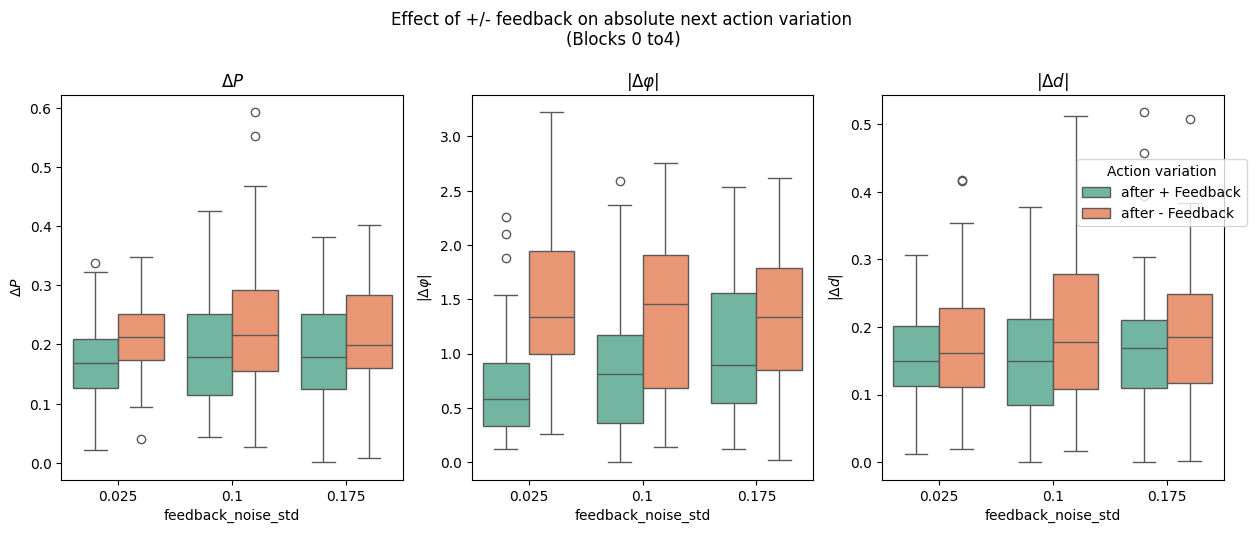

In [24]:
copy_df = subjects_df[subjects_df["study_name"]=="study_3"]

look_between_a = 0
look_between_b = 4


# Difference between raw points at times t and t+1
points = np.stack(copy_df["raw_points"])
Nsubj,Ntrials,Nactions,Npoints,Nfeatures = points.shape

points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
avg_dist = (dist_points1 + dist_points2)/2.0
flattened_distance = np.reshape(avg_dist,(Nsubj,-1))


# Observations : 
list_of_subjects_rtf = list(copy_df["realtime_values"])
all_subject_obs = {"gauge_level":[],"delta_gauge":[]}
for _s,_subj_feedback_series in enumerate(list_of_subjects_rtf):                   
    list_of_last_fb = []
    list_of_deltas = []
    for trial_series in _subj_feedback_series:
        trial_last_fbs = []
        trial_delta_fbs = []
        for timestep_series in trial_series:
            initial_feedback_value = timestep_series[0][...,1]
            final_feedback_value = timestep_series[-1][...,1]
            
            # print(timestep_series[0,:])
            
            trial_last_fbs.append(final_feedback_value)
            
            delta_feedback = final_feedback_value - initial_feedback_value
            trial_delta_fbs.append(delta_feedback)
                
        list_of_last_fb.append(trial_last_fbs)
        list_of_deltas.append(trial_delta_fbs)
    
    all_subject_obs["gauge_level" ].append(np.array(list_of_last_fb))
    all_subject_obs["delta_gauge" ].append(np.array(list_of_deltas))

# Action data :
all_barycenters = np.stack(copy_df["action_barycenters"],axis=0)
all_angles = np.stack(copy_df["action_angles"],axis=0)
all_distances = np.stack(copy_df["action_distances"],axis=0)
all_dist_to_center = vmap(vmap(vmap(lambda x : jnp.linalg.norm(x-jnp.array([0.5,0.5])))))(all_barycenters)

# Observation data :
gauge_levels = np.array(all_subject_obs["gauge_level"])
delta_gauges = np.array(all_subject_obs["delta_gauge"])

positive_feedbacks = delta_gauges>=0
negative_feedbacks = delta_gauges<0

delta_feedbacks = np.reshape(negative_feedbacks[:,look_between_a:look_between_b,1:-1],(Nsubj,-1))
                                # Remove the first timestep of each trial (reset to 0)
                                # And the last of each trial (no action after that one !)
                                # Also remove the second observation because only one action has been done before (thereofre, no action variation)

# print(negative_feedbacks)
print("{} negatives /{} positives".format(np.sum(negative_feedbacks),np.sum(positive_feedbacks)))
print("{} / {} remaining after removing edge actions".format(np.sum(delta_feedbacks),np.sum(1-delta_feedbacks)))


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,1:,:] - all_barycenters[:,:,:-1,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,1:] - all_angles[:,:,:-1]
# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,1:] - all_distances[:,:,:-1]
Nsubj = diff_barycenters.shape[0]

# Get the actions of interest :
rdiff_angle = np.reshape(diff_angle[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_barycenters = np.reshape(diff_barycenters[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_distances = np.reshape(diff_distances[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_points = np.reshape(avg_dist[:,look_between_a:look_between_b],(Nsubj,-1))

metrics_analyzed = [rdiff_barycenters,rdiff_angle,rdiff_distances]
labels_simple = ["dpos","dang","ddist"]
labels_analyzed = [r"$\Delta P$",r"$| \Delta \varphi |$",r"$| \Delta d |$"]
perf_categories = ["Poor","Middling","Good"]


print("Statistical Testing  ! #######################################")
from scipy.stats import shapiro,kruskal
from scipy.stats import kstest,wilcoxon
from scipy.stats import friedmanchisquare

import scikit_posthocs as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
for i,(metric,label,fancylabel) in enumerate(zip(metrics_analyzed,labels_simple,labels_analyzed)):
    print('Testing for metric {} ---------'.format(label))
    
    metric_analyzed = np.abs(metric) # Take the absolute value

    plot_df = copy_df[['subject_id' , 'final_performance', 'feedback_noise_std', 'performance_category']]
    
    assign_plus_fb,assign_ng_fb = [],[]
    for subj in range(Nsubj):
        action_variation_after_positive_feedback = metric_analyzed[subj,~delta_feedbacks[subj]]        
        action_variation_after_negative_feedback = metric_analyzed[subj,delta_feedbacks[subj]]

        assign_plus_fb.append(np.mean(action_variation_after_positive_feedback))
        assign_ng_fb.append(np.mean(action_variation_after_negative_feedback))
    
    plot_df["after + Feedback"] = assign_plus_fb
    plot_df["after - Feedback"] = assign_ng_fb
    
    # Reshape the data to long format
    df_long = plot_df.melt(id_vars=["subject_id","feedback_noise_std"], 
                    value_vars=["after + Feedback", "after - Feedback"], 
                    var_name="after_x", 
                    value_name=label)

    metric_by_group = list(df_long.groupby(['feedback_noise_std','after_x'])[label]) 
    for ((noise_category,fb_var),subjects_array) in metric_by_group :
        # logtime = np.log(subject_array.astype(float))
        print("  Shapiro test for normality - noise = {}, {} --->> {}".format(noise_category,fb_var,shapiro(subjects_array)))
    
    # Compare paired data : 
    print("  Wilcoxon signed-rank test for + and - feedbacks for all noise conditions :")
    for noise_category in np.unique(df_long["feedback_noise_std"]):
        
        pos_fb = df_long[(df_long["feedback_noise_std"]==noise_category) & (df_long["after_x"]=="after + Feedback")][label]
        neg_fb = df_long[(df_long["feedback_noise_std"]==noise_category) & (df_long["after_x"]=="after - Feedback")][label]
        print("     Noise category : {} -- Result : {}".format(noise_category,wilcoxon(pos_fb,neg_fb)))
    
    
    # GLMM fitting to explain the variation of the metric across mixed conditions :
    # print(df_long.head())
    model = smf.mixedlm(
        label + " ~ feedback_noise_std * after_x",  # Fixed effects
        df_long,
        groups=df_long["subject_id"],  # Random intercept per subject
        re_formula="1"  # Random intercept only
    )
    result = model.fit()

    # Print the summary
    print(result.summary())

print("##############################################################")





fig,firstaxs = plt.subplots(1,3,figsize=(15,5),sharex=True)

fig.suptitle("Effect of +/- feedback on absolute next action variation \n(Blocks {} to{})".format(look_between_a,look_between_b),y=1.05)
for i,(metric,label,fancylabel) in enumerate(zip(metrics_analyzed,labels_simple,labels_analyzed)):
    ax = firstaxs[i]
    metric_analyzed = np.abs(metric) # Take the absolute value

    plot_df = copy_df[['subject_id' , 'final_performance', 'feedback_noise_std', 'performance_category']]
    
    assign_plus_fb,assign_ng_fb = [],[]
    for subj in range(Nsubj):
        action_variation_after_positive_feedback = metric_analyzed[subj,~delta_feedbacks[subj]]        
        action_variation_after_negative_feedback = metric_analyzed[subj,delta_feedbacks[subj]]

        assign_plus_fb.append(np.mean(action_variation_after_positive_feedback))
        assign_ng_fb.append(np.mean(action_variation_after_negative_feedback))
    
    plot_df["after + Feedback"] = assign_plus_fb
    plot_df["after - Feedback"] = assign_ng_fb
    
    # Reshape the data to long format
    df_long = plot_df.melt(id_vars=["subject_id","feedback_noise_std"], 
                    value_vars=["after + Feedback", "after - Feedback"], 
                    var_name="after_x", 
                    value_name=label)
    
    g = sns.boxplot(
        ax = ax,
        data=df_long,
        x="feedback_noise_std",       # Categories on the x-axis
        y=label,          # Scalar values for the boxplot
        hue="after_x",     # Differentiate data1 and data2 with colors
        palette="Set2"      # Color palette
    )
    ax.set_ylabel(fancylabel)
    ax.set_title(fancylabel)
    ax.legend_.remove()
    
    # Add the legend to the figure
    plt.legend(
        title="Action variation",       # Legend title
        loc="upper left",       # Adjust position relative to figure
        bbox_to_anchor=(0.55, 0.85)  # Position: (x, y)
    )



Statistical Testing  ! #######################################
Testing for metric dpos ---------
  Shapiro test for normality - noise = 0.025, after + Feedback --->> ShapiroResult(statistic=np.float64(0.9633820193079303), pvalue=np.float64(0.1305125254721547))
  Shapiro test for normality - noise = 0.025, after - Feedback --->> ShapiroResult(statistic=np.float64(0.9906354909639998), pvalue=np.float64(0.9625147490620307))
  Shapiro test for normality - noise = 0.1, after + Feedback --->> ShapiroResult(statistic=np.float64(0.9265441136520789), pvalue=np.float64(0.005687655229123878))
  Shapiro test for normality - noise = 0.1, after - Feedback --->> ShapiroResult(statistic=np.float64(0.9349255043233737), pvalue=np.float64(0.011497320027025333))
  Shapiro test for normality - noise = 0.175, after + Feedback --->> ShapiroResult(statistic=np.float64(0.9752797625509947), pvalue=np.float64(0.38704735208479923))
  Shapiro test for normality - noise = 0.175, after - Feedback --->> ShapiroResult

C:\Users\annic\AppData\Local\Temp\ipykernel_35920\1983514563.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["after + Feedback"] = assign_plus_fb
C:\Users\annic\AppData\Local\Temp\ipykernel_35920\1983514563.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["after - Feedback"] = assign_ng_fb
c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the 

  Shapiro test for normality - noise = 0.025, after + Feedback --->> ShapiroResult(statistic=np.float64(0.8730000735951351), pvalue=np.float64(8.063161839132604e-05))
  Shapiro test for normality - noise = 0.025, after - Feedback --->> ShapiroResult(statistic=np.float64(0.9458876152963778), pvalue=np.float64(0.02524306337089272))
  Shapiro test for normality - noise = 0.1, after + Feedback --->> ShapiroResult(statistic=np.float64(0.9010927192257808), pvalue=np.float64(0.0007805256074104246))
  Shapiro test for normality - noise = 0.1, after - Feedback --->> ShapiroResult(statistic=np.float64(0.9555789342399106), pvalue=np.float64(0.07184048364145856))
  Shapiro test for normality - noise = 0.175, after + Feedback --->> ShapiroResult(statistic=np.float64(0.9376815628818704), pvalue=np.float64(0.012017217426888528))
  Shapiro test for normality - noise = 0.175, after - Feedback --->> ShapiroResult(statistic=np.float64(0.9797467181764654), pvalue=np.float64(0.5546882439089043))
  Wilcoxon

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\annic\AppData\Local\Temp\ipykernel_35920\1983514563.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["after + Feedback"] = assign_plus_fb
C:\Users\annic\AppData\Local\Temp\ipykernel_35920\1983514563.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

                                          Mixed Linear Model Regression Results
Model:                                    MixedLM                       Dependent Variable:                       ddist   
No. Observations:                         290                           Method:                                   REML    
No. Groups:                               145                           Scale:                                    0.0036  
Min. group size:                          2                             Log-Likelihood:                           279.1935
Max. group size:                          2                             Converged:                                Yes     
Mean group size:                          2.0                                                                             
--------------------------------------------------------------------------------------------------------------------------
                                                           

C:\Users\annic\AppData\Local\Temp\ipykernel_35920\1983514563.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["after + Feedback"] = assign_plus_fb
C:\Users\annic\AppData\Local\Temp\ipykernel_35920\1983514563.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["after - Feedback"] = assign_ng_fb
C:\Users\annic\AppData\Local\Temp\ipykernel_35920\1983514563.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

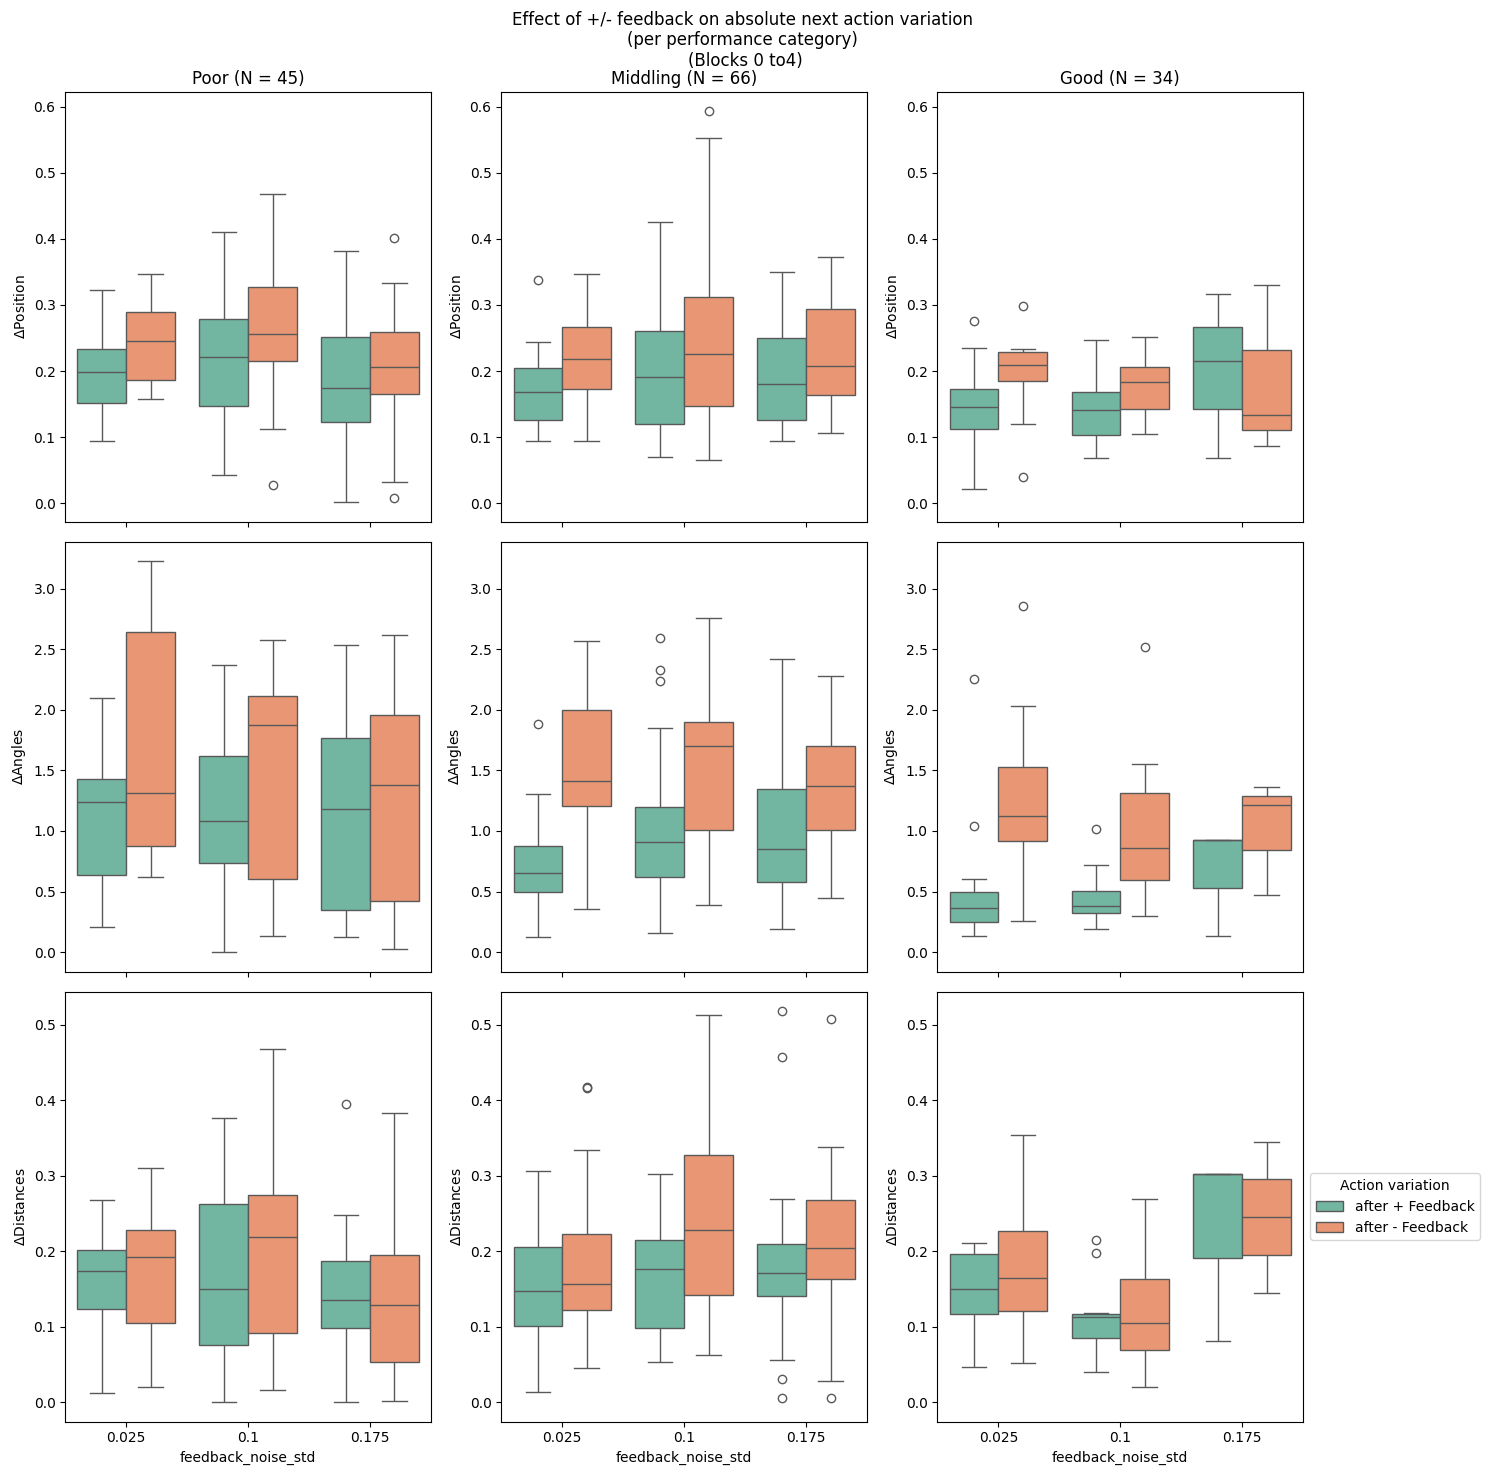

In [23]:
print("Statistical Testing  ! #######################################")
from scipy.stats import shapiro,kruskal
from scipy.stats import kstest,wilcoxon
from scipy.stats import friedmanchisquare

import scikit_posthocs as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

for i,(metric,label,fancylabel) in enumerate(zip(metrics_analyzed,labels_simple,labels_analyzed)):
    print('Testing for metric {} ---------'.format(label))
    
    metric_analyzed = np.abs(metric) # Take the absolute value

    plot_df = copy_df[['subject_id' , 'final_performance', 'feedback_noise_std', 'performance_category']]
    
    assign_plus_fb,assign_ng_fb = [],[]
    for subj in range(Nsubj):
        action_variation_after_positive_feedback = metric_analyzed[subj,~delta_feedbacks[subj]]        
        action_variation_after_negative_feedback = metric_analyzed[subj,delta_feedbacks[subj]]

        assign_plus_fb.append(np.mean(action_variation_after_positive_feedback))
        assign_ng_fb.append(np.mean(action_variation_after_negative_feedback))
    
    plot_df["after + Feedback"] = assign_plus_fb
    plot_df["after - Feedback"] = assign_ng_fb
    
    # Reshape the data to long format
    df_long = plot_df.melt(id_vars=["subject_id","feedback_noise_std","performance_category"], 
                    value_vars=["after + Feedback", "after - Feedback"], 
                    var_name="after_x", 
                    value_name=label)

    metric_by_group = list(df_long.groupby(['feedback_noise_std','after_x'])[label]) 
    for ((noise_category,fb_var),subjects_array) in metric_by_group :
        # logtime = np.log(subject_array.astype(float))
        print("  Shapiro test for normality - noise = {}, {} --->> {}".format(noise_category,fb_var,shapiro(subjects_array)))
    
    # Compare paired data : 
    print("  Wilcoxon signed-rank test for + and - feedbacks for all noise conditions :")
    for noise_category in np.unique(df_long["feedback_noise_std"]):
        for perfcat in np.unique(df_long["performance_category"]):
            pos_fb = df_long[(df_long["feedback_noise_std"]==noise_category) & (df_long["after_x"]=="after + Feedback") & (df_long["performance_category"]==perfcat)][label]
            neg_fb = df_long[(df_long["feedback_noise_std"]==noise_category) & (df_long["after_x"]=="after - Feedback") & (df_long["performance_category"]==perfcat)][label]
            print("     Noise category : {} + Perf category : {} -- Result : {}".format(noise_category,perfcat,wilcoxon(pos_fb,neg_fb)))
    
    
    # GLMM fitting to explain the variation of the metric across mixed conditions :
    # print(df_long.head())
    model = smf.mixedlm(
        label + " ~ feedback_noise_std * after_x * performance_category",  # Fixed effects
        df_long,
        groups=df_long["subject_id"],  # Random intercept per subject
        re_formula="1"  # Random intercept only
    )
    result = model.fit()

    # Print the summary
    print(result.summary())

print("##############################################################")

# Differentiate between good performers and bad performers :
fig,axs = plt.subplots(3,3,figsize=(15,15),sharex=True)
fig.suptitle("Effect of +/- feedback on absolute next action variation \n(per performance category) \n(Blocks {} to{})".format(look_between_a,look_between_b))
for i,(metric,label) in enumerate(zip(metrics_analyzed,["$\Delta$Position","$\Delta$Angles","$\Delta$Distances"])):
    
    axi = axs[i,0]
    metric_analyzed = np.abs(metric) # Take the absolute value
    
    for j,perf_interv in enumerate(perf_categories):
        ax = axs[i,j]
               
        plot_df = copy_df[['final_performance', 'feedback_noise_std', 'performance_category']]
        assign_plus_fb,assign_ng_fb = [],[]
        for subj in range(Nsubj):
            action_variation_after_positive_feedback = metric_analyzed[subj,~delta_feedbacks[subj]]        
            action_variation_after_negative_feedback = metric_analyzed[subj,delta_feedbacks[subj]]

            assign_plus_fb.append(np.mean(action_variation_after_positive_feedback))
            assign_ng_fb.append(np.mean(action_variation_after_negative_feedback))
        
        plot_df["after + Feedback"] = assign_plus_fb
        plot_df["after - Feedback"] = assign_ng_fb

        plot_df = plot_df[plot_df['performance_category']==perf_interv]

        # Reshape the data to long format
        df_long = plot_df.melt(id_vars="feedback_noise_std", 
                        value_vars=["after + Feedback", "after - Feedback"], 
                        var_name="after_x", 
                        value_name=label)
        
        g = sns.boxplot(
            ax = ax,
            data=df_long,
            x="feedback_noise_std",       # Categories on the x-axis
            y=label,          # Scalar values for the boxplot
            hue="after_x",     # Differentiate data1 and data2 with colors
            palette="Set2"      # Color palette
        )
        try :
            ax.legend_.remove()
        except:
            pass
        
        ax.sharey(firstaxs[i])        
        if i == 0:
            ax.set_title("{} (N = {})".format(perf_interv,plot_df.shape[0]))           
# Add the legend to the figure
plt.legend(
    title="Action variation",       # Legend title
    loc="center left",       # Adjust position relative to figure
    bbox_to_anchor=(1, 0.5)  # Position: (x, y)
)
fig.tight_layout()
fig.show()




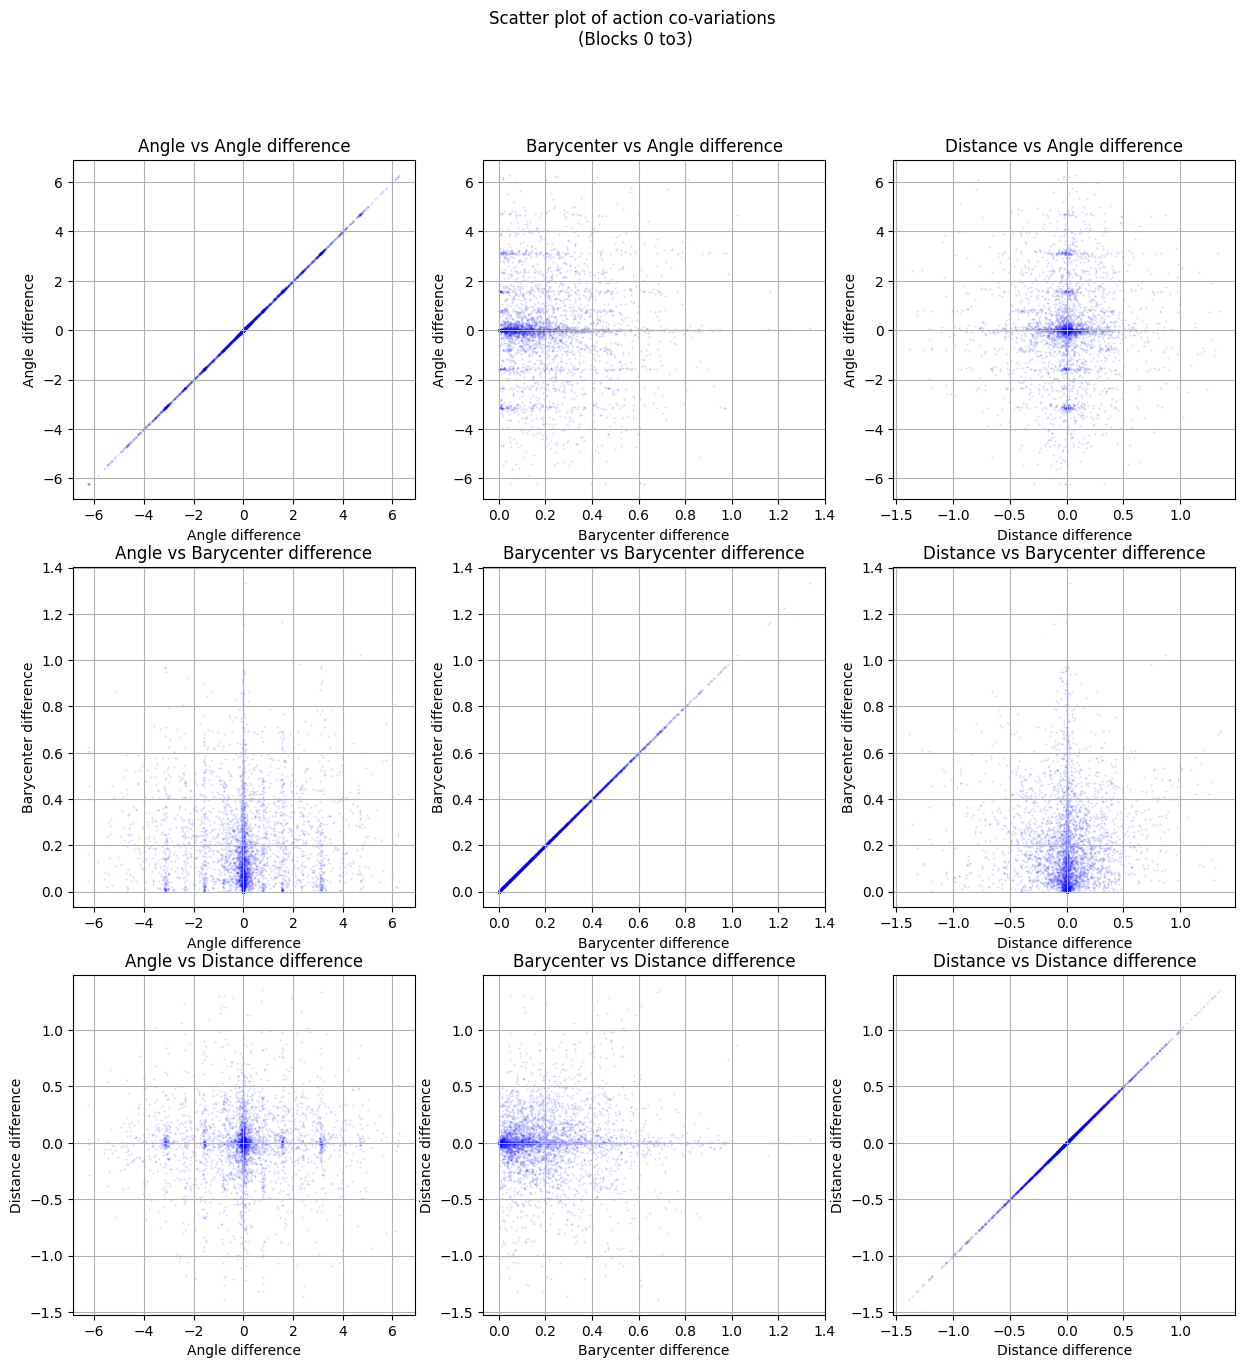

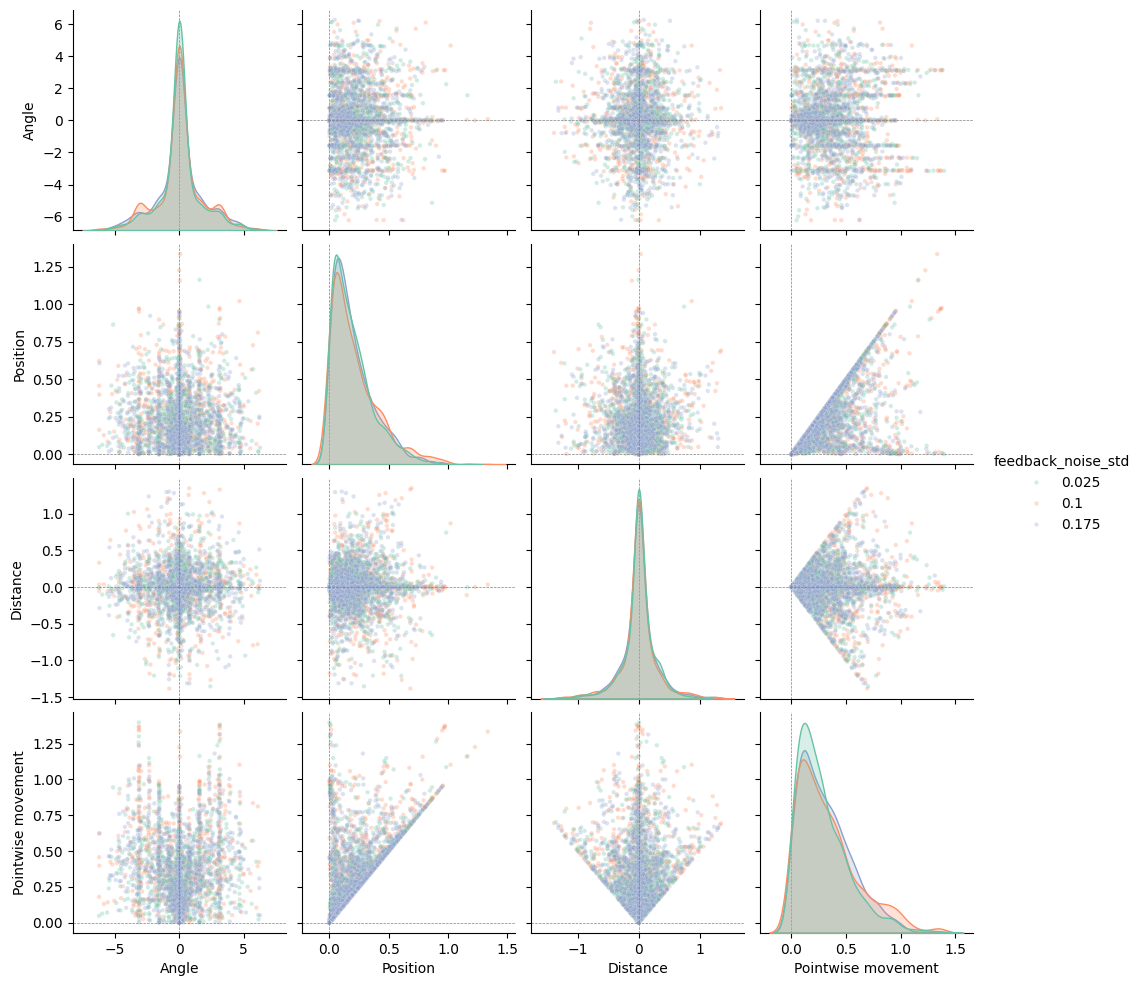

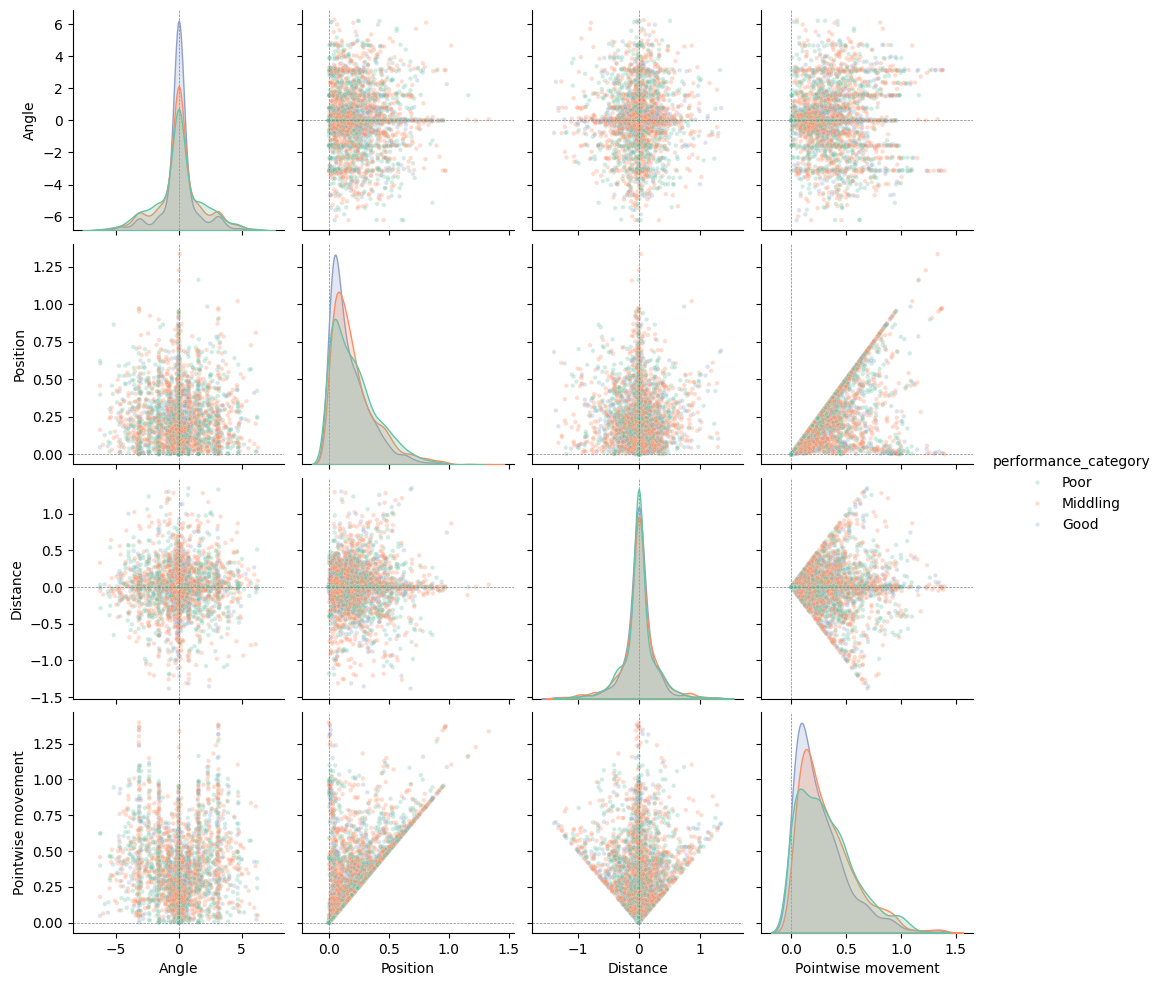

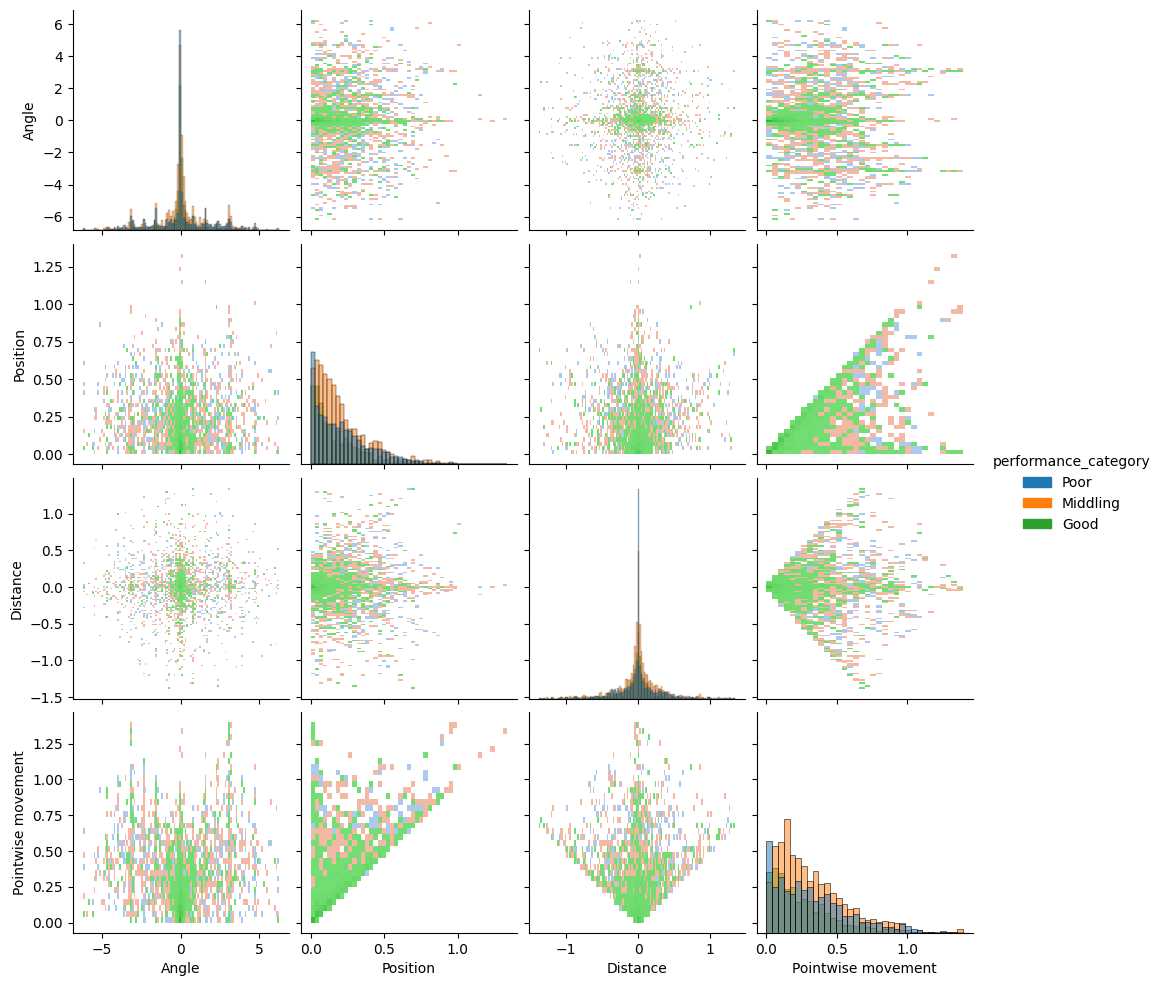

In [8]:

plot_these = list(zip([rdiff_angle,rdiff_barycenters,rdiff_distances],["Angle","Barycenter","Distance"]))   
fig,axs = plt.subplots(3,3,figsize=(15,15))
fig.suptitle("Scatter plot of action co-variations \n(Blocks {} to{})".format(look_between_a,look_between_b))
for xdim,(xmetric,xlabel) in enumerate(plot_these):
    for ydim,(ymetric,ylabel) in enumerate(plot_these):
        ax = axs[ydim,xdim]
        ax.grid()
        ax.set_xlabel("{} difference".format(xlabel))
        ax.set_ylabel("{} difference".format(ylabel))
        ax.set_title("{} vs {} difference".format(xlabel,ylabel))
        # for subj in range(Nsubj):
        ax.scatter(xmetric,ymetric,c="b",alpha=0.1,s=0.5)


plot_df = copy_df[['feedback_noise_std','final_performance','performance_category']].copy()
plot_df["Angle"] = list(rdiff_angle)
plot_df["Position"] = list(rdiff_barycenters)
plot_df["Distance"] = list(rdiff_distances)
plot_df["Points"] = list(rdiff_points)
# plot_df['performance_category'] = pd.cut(plot_df['final_performance'], bins=np.linspace(0-1e-5,1+1e-5,4), labels=["0-0.33","0.33-0.67","0.37-1.0"], include_lowest=True)






# Create a new DataFrame with exploded rows
exploded_df = pd.DataFrame({
    'feedback_noise_std': np.repeat(plot_df['feedback_noise_std'], plot_df['Angle'].map(len)),
    "performance_category" : np.repeat(plot_df['performance_category'], plot_df['Angle'].map(len)),
    'Angle': np.concatenate(plot_df['Angle'].values),
    "Position": np.concatenate(plot_df['Position'].values),
    "Distance" : np.concatenate(plot_df['Distance'].values),
    "Pointwise movement" : np.concatenate(plot_df['Points'].values),
})



# fig.suptitle("Scatter plot of action co-variations \n(Blocks {} to{})".format(look_between_a,look_between_b))
g = sns.pairplot(exploded_df, hue="feedback_noise_std", palette="Set2", diag_kind="kde", height=2.5,
                diag_kws=dict(common_norm=False), plot_kws={'s': 10, 'alpha': 0.3})
    
for i,axline in enumerate(g.axes):
    for j, ax in enumerate(axline):
        ax.axvline(x=0, ls='--', linewidth=0.5, c='grey')
        if i != j :
            ax.axhline(y=0, ls='--', linewidth=0.5, c='grey')
    
g = sns.pairplot(exploded_df[['performance_category','Angle','Position','Distance','Pointwise movement']], hue="performance_category",hue_order=["Poor","Middling","Good"], palette="Set2", diag_kind="kde", 
                 diag_kws=dict(common_norm=False), height=2.5,
                 plot_kws={'s': 10, 'alpha': 0.3})
for i,axline in enumerate(g.axes):
    for j, ax in enumerate(axline):
        ax.axvline(x=0, ls='--', linewidth=0.5, c='grey')
        if i != j :
            ax.axhline(y=0, ls='--', linewidth=0.5, c='grey')
            
g = sns.pairplot(exploded_df[['performance_category','Angle','Position','Distance','Pointwise movement']], kind='hist',hue="performance_category",hue_order=["Poor","Middling","Good"])
# for i,axline in enumerate(g.axes):
#     for j, ax in enumerate(axline):
#         ax.axvline(x=0, ls='--', linewidth=0.5, c='grey')
#         if i != j :
#             ax.axhline(y=0, ls='--', linewidth=0.5, c='grey')        

5352 negatives /10598 positives
4744 / 8306 remaining after removing edge actions
(145, 11, 9)
(145, 11, 9)
(145, 11, 9)
(145, 27)
     feedback_noise_std  final_performance performance_category  \
55                0.100           1.000000                 Good   
56                0.100           0.629516             Middling   
57                0.100           0.520036             Middling   
58                0.100           0.326501                 Poor   
59                0.100           0.964645                 Good   
..                  ...                ...                  ...   
195               0.175           0.561067             Middling   
196               0.175           0.790539             Middling   
197               0.175           0.775167             Middling   
198               0.175           0.206026                 Poor   
199               0.175           0.929289             Middling   

                                                 Angle  \
55   [

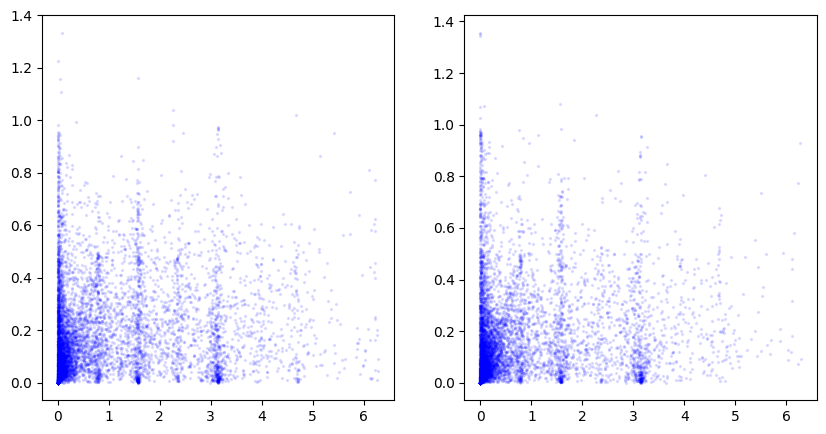

In [9]:
# Difference between raw points at times t and t+1
points = np.stack(copy_df["raw_points"])
points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)
avg_dist = (dist_points1 + dist_points2)/2.0


positive_feedbacks = delta_gauges>=0
negative_feedbacks = delta_gauges<0
delta_feedbacks = np.reshape(negative_feedbacks[:,:,1:-1],(Nsubj,-1))
                                # Remove the first timestep of each trial (reset to 0)
                                # And the last of each trial (no action after that one !)

# print(negative_feedbacks)
print("{} negatives /{} positives".format(np.sum(negative_feedbacks),np.sum(positive_feedbacks)))
print("{} / {} remaining after removing edge actions".format(np.sum(delta_feedbacks),np.sum(1-delta_feedbacks)))


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,:-1,:] - all_barycenters[:,:,1:,:],axis=-1)

# np.linalg.norm(all_barycenters[:,:,:-1,:] - all_barycenters[:,:,1:,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,:-1] - all_angles[:,:,1:]

# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,:-1] - all_distances[:,:,1:]

Nsubj = diff_barycenters.shape[0]


print(diff_distances.shape)
print(diff_barycenters.shape)
print(diff_angle.shape)
print(flattened_distance.shape)


# Get the actions of interest :
diff_angle = np.reshape(np.abs(diff_angle[:,:-1]),(Nsubj,-1))
diff_barycenters = np.reshape(np.abs(diff_barycenters[:,:-1]),(Nsubj,-1))
diff_distances = np.reshape(np.abs(diff_distances[:,:-1]),(Nsubj,-1))
diff_points = np.reshape(np.abs(avg_dist[:,:-1]),(Nsubj,-1))

# plot_df = subjects_df[['feedback_noise_std','final_performance']].copy()
# plot_df["Angle"] = list(diff_angle)
# plot_df["Position"] = list(diff_barycenters)
# plot_df["Distance"] = list(diff_distances)
# plot_df["Points"] = list(diff_points)
# plot_df['performance_category'] = pd.cut(plot_df['final_performance'], bins=np.linspace(0-1e-5,1+1e-5,4), labels=["0-0.33","0.33-0.67","0.37-1.0"], include_lowest=True)


# plot_df = plot_df[plot_df['final_performance'].between(*perf_interv)]

print(plot_df)
print(exploded_df)
fig,axs = plt.subplots(1,2,figsize=(10,5))
window = 50
for subj in range(Nsubj):
    axs[0].scatter(diff_angle[subj][:window],diff_barycenters[subj][:window],alpha=0.1,s=2,color='blue')
    axs[1].scatter(diff_angle[subj][-window:],diff_barycenters[subj][-window:],alpha=0.1,s=2,color='blue')

5352 negatives /10598 positives
4744 / 8306 remaining after removing edge actions
(145, 11, 9)
(145, 11, 9)
(145, 11, 9)
(145, 27)
     feedback_noise_std  final_performance performance_category  \
55                0.100           1.000000                 Good   
56                0.100           0.629516             Middling   
57                0.100           0.520036             Middling   
58                0.100           0.326501                 Poor   
59                0.100           0.964645                 Good   
..                  ...                ...                  ...   
195               0.175           0.561067             Middling   
196               0.175           0.790539             Middling   
197               0.175           0.775167             Middling   
198               0.175           0.206026                 Poor   
199               0.175           0.929289             Middling   

                                                 Angle  \
55   [

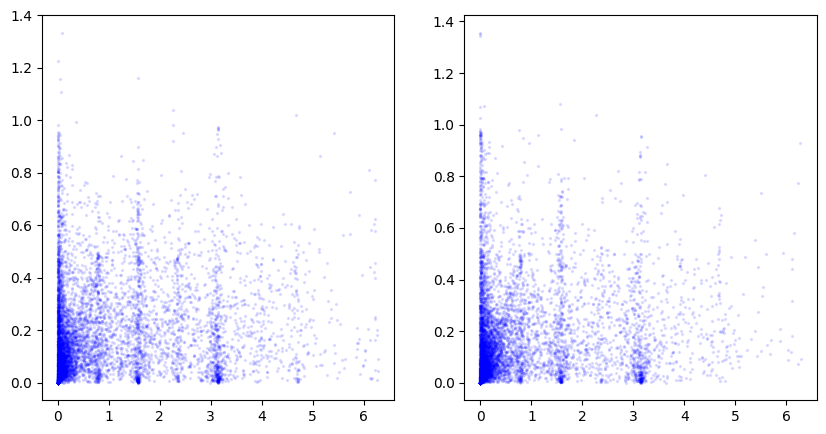

In [10]:
# Difference between raw points at times t and t+1
points = np.stack(copy_df["raw_points"])
points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)
avg_dist = (dist_points1 + dist_points2)/2.0


positive_feedbacks = delta_gauges>=0
negative_feedbacks = delta_gauges<0
delta_feedbacks = np.reshape(negative_feedbacks[:,:,1:-1],(Nsubj,-1))
                                # Remove the first timestep of each trial (reset to 0)
                                # And the last of each trial (no action after that one !)

# print(negative_feedbacks)
print("{} negatives /{} positives".format(np.sum(negative_feedbacks),np.sum(positive_feedbacks)))
print("{} / {} remaining after removing edge actions".format(np.sum(delta_feedbacks),np.sum(1-delta_feedbacks)))


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,:-1,:] - all_barycenters[:,:,1:,:],axis=-1)

# np.linalg.norm(all_barycenters[:,:,:-1,:] - all_barycenters[:,:,1:,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,:-1] - all_angles[:,:,1:]

# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,:-1] - all_distances[:,:,1:]

Nsubj = diff_barycenters.shape[0]


print(diff_distances.shape)
print(diff_barycenters.shape)
print(diff_angle.shape)
print(flattened_distance.shape)


# Get the actions of interest :
diff_angle = np.reshape(np.abs(diff_angle[:,:-1]),(Nsubj,-1))
diff_barycenters = np.reshape(np.abs(diff_barycenters[:,:-1]),(Nsubj,-1))
diff_distances = np.reshape(np.abs(diff_distances[:,:-1]),(Nsubj,-1))
diff_points = np.reshape(np.abs(avg_dist[:,:-1]),(Nsubj,-1))

# plot_df = subjects_df[['feedback_noise_std','final_performance']].copy()
# plot_df["Angle"] = list(diff_angle)
# plot_df["Position"] = list(diff_barycenters)
# plot_df["Distance"] = list(diff_distances)
# plot_df["Points"] = list(diff_points)
# plot_df['performance_category'] = pd.cut(plot_df['final_performance'], bins=np.linspace(0-1e-5,1+1e-5,4), labels=["0-0.33","0.33-0.67","0.37-1.0"], include_lowest=True)


# plot_df = plot_df[plot_df['final_performance'].between(*perf_interv)]

print(plot_df)
print(exploded_df)
fig,axs = plt.subplots(1,2,figsize=(10,5))
window = 50
for subj in range(Nsubj):
    axs[0].scatter(diff_angle[subj][:window],diff_barycenters[subj][:window],alpha=0.1,s=2,color='blue')
    axs[1].scatter(diff_angle[subj][-window:],diff_barycenters[subj][-window:],alpha=0.1,s=2,color='blue')